In [1]:

import os
import numpy as np
from PIL import Image
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
root = './k_mean_data/'

# Image Denoise

In [3]:
def get_bin_table(threshold=128):
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    return table

def remove_noise_pixel(img, noise_point_list):
    for item in noise_point_list:
        img.putpixel((item[0], item[1]), 1)

def collect_noise_point(img):
    noise_point_list = []
    for x in range(img.width):
        for y in range(img.height):
            res_9 = sum_9_region_new(img, x, y)
            if (0 < res_9 < 3) and img.getpixel((x, y)) == 0:
                pos = (x, y)
                noise_point_list.append(pos)
    return noise_point_list

def sum_9_region_new(img, x, y):
    cur_pixel = img.getpixel((x, y))
    width = img.width
    height = img.height
    if cur_pixel == 1:
        return 0
    if y < 3:
        return 1
    elif y > height - 3:
        return 1
    else:
        if x < 3:
            return 1
        elif x == width - 1:
            return 1
        else:
            sum = img.getpixel((x - 1, y - 1)) \
                  + img.getpixel((x - 1, y)) \
                  + img.getpixel((x - 1, y + 1)) \
                  + img.getpixel((x, y - 1)) \
                  + cur_pixel \
                  + img.getpixel((x, y + 1)) \
                  + img.getpixel((x + 1, y - 1)) \
                  + img.getpixel((x + 1, y)) \
                  + img.getpixel((x + 1, y + 1))
            return 9 - sum


In [4]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get label

In [3]:
label_list = {}

f = open('training data dic.txt', 'r', encoding="utf-8")
for idx, line in enumerate(f.readlines()):
    if idx == 50:
        break
    label_list[line[0]] = idx

# Load data

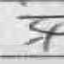

In [8]:
is_denoise = False
data = []
files = []
labels = []
binary = None
for idx, dir_ in enumerate(os.listdir(root)):
    for _, file in enumerate(os.listdir(root + '/' + dir_)):
        img_path = root + dir_ + '/' + file
        img = Image.open(img_path)
        img = img.resize((64, 64))
        im = np.array(img).reshape(-1)
        if is_denoise:
            table = get_bin_table(np.mean(im))
            binary = img.point(table, '1')
            noise_point_list = collect_noise_point(binary)
            remove_noise_pixel(binary, noise_point_list)
            im = np.array(binary).reshape(-1)
        data.append(im)
        files.append(img_path)
        labels.append(label_list[file[-5:-4]])
data = np.array(data)
img

In [4]:
print(data.shape)
len(labels)

NameError: name 'data' is not defined

# Normalize data

In [9]:
nor_data = preprocessing.normalize(data)
print(nor_data[0])

ValueError: Found array with dim 3. the normalize function expected <= 2.

# Dimension reduce with PCA


In [27]:
from sklearn.decomposition import PCA
is_reduce_dim = False
if is_reduce_dim:
    pca = PCA(n_components=0.8, random_state=0)
    pca.fit(nor_data)
    nor_data = pca.transform(nor_data)
    print(nor_data.shpae)

AttributeError: 'numpy.ndarray' object has no attribute 'shpae'

# Split training set and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(nor_data, labels, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(len(y_train))
print(len(y_val))

(2304, 4096)
(577, 4096)
2304
577


# K-nearest neighbors Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [1, 5, 9, 15, 50, 100]
for n_neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbor, algorithm='auto', leaf_size=1, weights='distance')
    knn.fit(X_train, y_train)
    print("Evaluation:", n_neighbor, "n_neighbor")
    y_pred = knn.predict(X_val)
    knn_f1 = metrics.f1_score(y_val, y_pred, average= "weighted")
    print("F1 score: {}".format(knn_f1))
    knn_accuracy = metrics.accuracy_score(y_val, y_pred)
    print("Accuracy score: {}".format(knn_accuracy))
    print(metrics.classification_report(y_val[:10],y_pred[:10]))

Evaluation: 1 n_neighbor
F1 score: 0.19306619758861826
Accuracy score: 0.19410745233968804
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       1.00      1.00      1.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         0
          47       0.00      0.00      0.00 

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: 5 n_neighbor
F1 score: 0.20071272336772938
Accuracy score: 0.2027729636048527
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       1.00      1.00      1.00         1
          41       0.00      0.00      0.00         0
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         1
          49       0.00      0.00      0.00  

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.19024794551809313
Accuracy score: 0.1923743500866551
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       1.00      1.00      1.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         1

    accuracy                           0.20        10
   macro avg   

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.21472557242809906
Accuracy score: 0.21490467937608318
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       1.00      1.00      1.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         1

    accuracy  

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.17945462379818436
Accuracy score: 0.19064124783362218
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         0

    accuracy                           0.20        10
   macro avg  

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.12462057431375549
Accuracy score: 0.15077989601386482
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       0.0
          17       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00       0.0
          35       0.00      0.00      0.00       0.0
          36       0.00      0.00      0.00       1.0
          37       0.00      0.00      0.00       1.0
          42       0.00      0.00      0.00       1.0
          44       0.00      0.00      0.00       1.0
          47       0.00      0.00      0.00       1.0
          48       0.00      0.00      0.00       0.0

    accuracy  

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
param_grid = {'n_neighbors':n_neighbors, 'algorithm':['auto'], 'leaf_size': [1], 'weights':['distance']}
knn = KNeighborsClassifier()
gridKNN = GridSearchCV(knn, param_grid, refit=True, verbose=2, n_jobs=4)
gridKNN.fit(X_train, y_train)
print(gridKNN.best_score_)
print(gridKNN.best_params_)
print(gridKNN.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   50.8s finished


0.203128359898142
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=1, n_neighbors=9, weights='distance')


# KNN report and analysis

-----------------KNN Report---------------
F1 score: 0.19024794551809313
Accuracy score: 0.1923743500866551
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
Plotting confusion matrix for random 10 classes


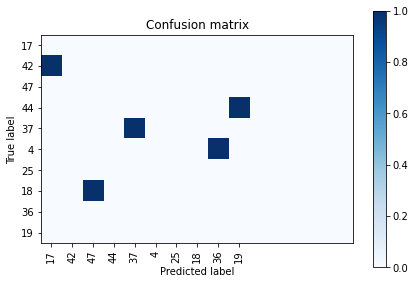

              precision    recall  f1-score   support

           0       0.12      0.21      0.15        14
           1       0.33      0.10      0.15        10
           2       0.30      0.38      0.33         8
           3       0.00      0.00      0.00         3
           4       0.12      0.12      0.12        17
           5       0.31      0.42      0.36        12
           6       0.33      0.20      0.25        10
           7       0.22      0.29      0.25        14
           8       0.02      0.12      0.04         8
           9       0.50      0.38      0.43        13
          10       0.12      0.10      0.11        10
          11       0.17      0.06      0.09        17
          12       0.60      0.23      0.33        13
          13       0.75      0.30      0.43        10
          14       0.31      0.50      0.38         8
          15       0.50      0.19      0.27        16
          16       0.12      0.10      0.11        10
          17       0.29    

In [33]:
y_pred_knn = gridKNN.predict(X_val)
knn_f1 = metrics.f1_score(y_val, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_val, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_val[:10], y_pred_knn[:10])
print("-----------------KNN Report---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix for random 10 classes: \n", knn_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(knn_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_knn))


# Naive Bayes Classifier

In [34]:
from sklearn.naive_bayes import *
if not is_reduce_dim:
    Categorical_NB = CategoricalNB()
    Categorical_NB.fit(X_train, y_train)

    Complement_NB = ComplementNB()
    Complement_NB.fit(X_train, y_train)

    Gaussian_NB = GaussianNB()
    Gaussian_NB.fit(X_train, y_train)

    Multinomial_NB = MultinomialNB()
    Multinomial_NB.fit(X_train, y_train)


ValueError: Negative values in data passed to ComplementNB (input X)

# Naive Bayes Classifier report and analysis

-----------------Naive Bayes Classifier Report---------------
CategoricalNB F1 score: 0.0007132835803298788 and Accuracy score: 0.019064124783362217
ComplementNB F1 score: 0.19131295919341063 and Accuracy score: 0.22876949740034663
GaussianNB F1 score: 0.23437753018737778 and Accuracy score: 0.24610051993067592
MultinomialNB F1 score: 0.05428965555834216 and Accuracy score: 0.09532062391681109
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0

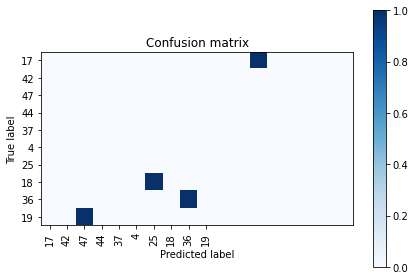

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        14
           1       0.00      0.00      0.00        10
           2       0.14      0.12      0.13         8
           3       0.00      0.00      0.00         3
           4       0.08      0.06      0.07        17
           5       0.50      0.42      0.45        12
           6       0.17      0.20      0.18        10
           7       0.17      0.21      0.19        14
           8       0.33      0.38      0.35         8
           9       0.21      0.23      0.22        13
          10       0.25      0.10      0.14        10
          11       0.25      0.18      0.21        17
          12       0.36      0.38      0.37        13
          13       0.33      0.50      0.40        10
          14       0.17      0.50      0.26         8
          15       0.86      0.38      0.52        16
          16       0.62      0.50      0.56        10
          17       0.00    

In [18]:
y_pred_Categorical_NB = Categorical_NB.predict(X_val)
y_pred_Complement_NB = Complement_NB.predict(X_val)
y_pred_Gaussian_NB = Gaussian_NB.predict(X_val)
y_pred_Multinomial_NB = Multinomial_NB.predict(X_val)

Categorical_NB_f1 = metrics.f1_score(y_val, y_pred_Categorical_NB, average= "weighted")
Complement_NB_f1 = metrics.f1_score(y_val, y_pred_Complement_NB, average= "weighted")
Gaussian_NB_f1 = metrics.f1_score(y_val, y_pred_Gaussian_NB, average= "weighted")
Multinomial_NB_f1 = metrics.f1_score(y_val, y_pred_Multinomial_NB, average= "weighted")

Categorical_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Categorical_NB)
Complement_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Complement_NB)
Gaussian_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Gaussian_NB)
Multinomial_NB_accuracy = metrics.accuracy_score(y_val, y_pred_Multinomial_NB)

Gaussian_NB_cm = metrics.confusion_matrix(y_val[:10], y_pred_Gaussian_NB[:10])

print("-----------------Naive Bayes Classifier Report---------------")
print("CategoricalNB F1 score: {} and Accuracy score: {}".format(Categorical_NB_f1, Categorical_NB_accuracy))
print("ComplementNB F1 score: {} and Accuracy score: {}".format(Complement_NB_f1, Complement_NB_accuracy))
print("GaussianNB F1 score: {} and Accuracy score: {}".format(Gaussian_NB_f1, Gaussian_NB_accuracy))
print("MultinomialNB F1 score: {} and Accuracy score: {}".format(Multinomial_NB_f1, Multinomial_NB_accuracy))
print("Confusion matrix for random 10 classes: \n", Gaussian_NB_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(Gaussian_NB_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_Gaussian_NB))

# SVM Classifier

In [35]:
from sklearn.svm import SVC

kernels = ['poly', 'rbf', 'sigmoid','linear']
for kernel in kernels:
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)
    svc_f1 = metrics.f1_score(y_val, y_pred, average= "weighted")
    print("Evaluation:", kernel, "kernel")
    print("F1 score: {}".format(svc_f1))
    svc_accuracy = metrics.accuracy_score(y_val, y_pred)
    print("Accuracy score: {}".format(svc_accuracy))
    print(metrics.classification_report(y_val[:10],y_pred[:10]))


Evaluation: poly kernel
F1 score: 0.11290796480194293
Accuracy score: 0.10745233968804159
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         1

    accuracy                           0.10        10
   macro avg       0.08      0.08      0.08        10
weighted avg       0.10      0.10      0.10 

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: rbf kernel
F1 score: 0.33746559903466355
Accuracy score: 0.3587521663778163
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       1.00      1.00      1.00         1
          45       0.00      0.00      0.00         0
          47       0.00      0.00      0.00         1

    accuracy                           0.20   

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: sigmoid kernel
F1 score: 0.309407901170187
Accuracy score: 0.3223570190641248
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          37       1.00      1.00      1.00         1
          42       0.00      0.00      0.00         1
          44       1.00      1.00      1.00         1
          47       0.00      0.00      0.00         1
          49       0.00      0.00      0.00         0

    accuracy                           0.40        10
   macro avg       0.29      0.29      0.29 

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: linear kernel
F1 score: 0.009059769575039818
Accuracy score: 0.03119584055459272
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0
          17       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       1.0
          21       0.00      0.00      0.00       0.0
          25       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00       0.0
          36       0.00      0.00      0.00       1.0
          37       0.00      0.00      0.00       1.0
          42       0.00      0.00      0.00       1.0
          44       0.00      0.00      0.00       1.0
          47       0.00      0.00      0.00       1.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.

c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\zxcz1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': ['scale', 'auto'],'kernel': kernels[:2]}
svc = SVC()
grid_svc = GridSearchCV(svc, param_grid, refit=True, verbose=2, n_jobs=4)
grid_svc.fit(X_train, y_train)
print(grid_svc.best_score_)
print(grid_svc.best_params_)
print(grid_svc.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   45.1s finished


0.3441884372347449
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=10)


# SVM Classifier report and analysis

-----------------SVM Classifier Report---------------
F1 score: 0.372472746369572
Accuracy score: 0.38128249566724437
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Plotting confusion matrix for random 10 classes


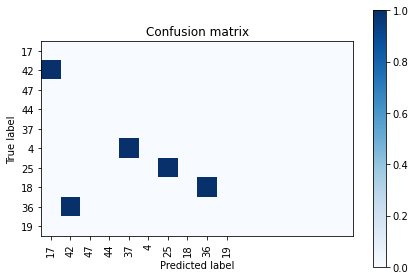

              precision    recall  f1-score   support

           0       0.23      0.21      0.22        14
           1       0.09      0.10      0.10        10
           2       0.27      0.38      0.32         8
           3       0.25      0.67      0.36         3
           4       0.17      0.12      0.14        17
           5       0.47      0.67      0.55        12
           6       0.37      0.70      0.48        10
           7       0.39      0.50      0.44        14
           8       0.27      0.38      0.32         8
           9       0.45      0.38      0.42        13
          10       0.38      0.30      0.33        10
          11       0.40      0.47      0.43        17
          12       0.35      0.46      0.40        13
          13       0.42      0.50      0.45        10
          14       0.45      0.62      0.53         8
          15       0.77      0.62      0.69        16
          16       0.53      0.80      0.64        10
          17       0.67    

In [37]:
y_pred_svc = grid_svc.predict(X_val)
svc_f1 = metrics.f1_score(y_val, y_pred_svc, average= "weighted")
svc_accuracy = metrics.accuracy_score(y_val, y_pred_svc)
svc_cm = metrics.confusion_matrix(y_val[:10], y_pred_svc[:10])
print("-----------------SVM Classifier Report---------------")
print("F1 score: {}".format(svc_f1))
print("Accuracy score: {}".format(svc_accuracy))
print("Confusion matrix for random 10 classes: \n", svc_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(svc_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_svc))

# MLP Classifier

In [40]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(512, 512, 64), verbose=2, max_iter=500)
clf.fit(X_train, y_train)

Iteration 1, loss = 3.91851740
Iteration 2, loss = 3.90668161
Iteration 3, loss = 3.89493631
Iteration 4, loss = 3.87659171
Iteration 5, loss = 3.84345641
Iteration 6, loss = 3.78277609
Iteration 7, loss = 3.68657792
Iteration 8, loss = 3.56533681
Iteration 9, loss = 3.44133515
Iteration 10, loss = 3.32320171
Iteration 11, loss = 3.21317001
Iteration 12, loss = 3.11151858
Iteration 13, loss = 3.02804539
Iteration 14, loss = 2.95906798
Iteration 15, loss = 2.88374073
Iteration 16, loss = 2.81685173
Iteration 17, loss = 2.75176799
Iteration 18, loss = 2.69673035
Iteration 19, loss = 2.66375226
Iteration 20, loss = 2.62564347
Iteration 21, loss = 2.58992327
Iteration 22, loss = 2.54574885
Iteration 23, loss = 2.52014356
Iteration 24, loss = 2.49599454
Iteration 25, loss = 2.46306056
Iteration 26, loss = 2.43552794
Iteration 27, loss = 2.40927351
Iteration 28, loss = 2.38796950
Iteration 29, loss = 2.36850509
Iteration 30, loss = 2.33187247
Iteration 31, loss = 2.30099040
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(512, 512, 64), max_iter=500, verbose=2)

# MLP Classifier report and analysis

-----------------MLP Classifier Report---------------
F1 score: 0.2535845676284849
Accuracy score: 0.24783362218370883
Confusion matrix for random 10 classes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
Plotting confusion matrix for random 10 classes


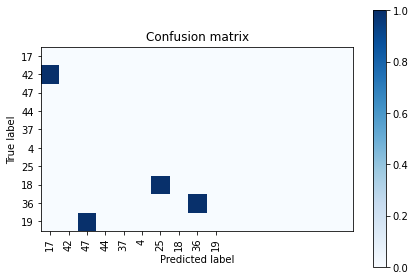

              precision    recall  f1-score   support

           0       0.29      0.29      0.29        14
           1       0.00      0.00      0.00        10
           2       0.38      0.38      0.38         8
           3       0.00      0.00      0.00         3
           4       0.29      0.12      0.17        17
           5       0.33      0.25      0.29        12
           6       0.36      0.50      0.42        10
           7       0.27      0.29      0.28        14
           8       0.25      0.25      0.25         8
           9       0.29      0.15      0.20        13
          10       0.08      0.10      0.09        10
          11       0.42      0.29      0.34        17
          12       0.36      0.31      0.33        13
          13       0.25      0.30      0.27        10
          14       0.25      0.38      0.30         8
          15       0.71      0.31      0.43        16
          16       0.42      0.50      0.45        10
          17       0.33    

In [41]:
y_pred_mlp = clf.predict(X_val)
mlp_f1 = metrics.f1_score(y_val, y_pred_mlp, average= "weighted")
mlp_accuracy = metrics.accuracy_score(y_val, y_pred_mlp)
mlp_cm = metrics.confusion_matrix(y_val[:10], y_pred_mlp[:10])
print("-----------------MLP Classifier Report---------------")
print("F1 score: {}".format(mlp_f1))
print("Accuracy score: {}".format(mlp_accuracy))
print("Confusion matrix for random 10 classes: \n", mlp_cm)
print('Plotting confusion matrix for random 10 classes')

plt.figure()
plot_confusion_matrix(mlp_cm[:10], y_val[:10])
plt.show()

print(metrics.classification_report(y_val, y_pred_mlp))
